# Underwater Temperature Dataset

## Motivation:

I chose the "Underwater Temperature dataset" due to its relevance and importance in understanding the dynamics of marine ecosystems and climate change. Temperature is a critical parameter affecting various aspects of the underwater environment, including biological processes, ocean currents, and the overall health of marine life.

By analyzing this dataset, researchers and scientists can gain insights into the long-term trends, seasonal variations, and spatial distribution of underwater temperatures. These findings can contribute to our understanding of climate change impacts on marine ecosystems, help assess the health of coral reefs, study the migration patterns of marine species, and support the development of sustainable ocean management strategies.

### A. About the Dataset and Data Acquisition

The dataset I have chosen is 'Underwater Surface Temperature Dataset'. This dataset contains underwater temperature (°C) data from seven islands and two submerged rocky reefs along the Santa Catarina coast, southern Brazil, between 26°22’ S and 28°26’ S. Temperature records were acquired every 20 minutes, between December 2012 and July 2014, using a HOBO Pendant® Temperature Data Logger UA-002. The data loggers were installed underwater by SCUBA divers and anchored to the rocky reef with epoxy at 5 m and 12 m depth, in the islands, and at 22 m depth in the submerged reefs. Due to equipment loss, some depths are missing for specific sites. The dataset is structured in seven variables: Site, Latitude, Longitude, Date, Time of Sampling, Temperature (°C) and Depth (meters).

Description of the raw dataset: The underwater surface temperature dataset contains measurements of sea surface temperature (SST) in degrees Celsius (°C) taken by satellite sensors between 1981 and 2020. The dataset covers the entire globe with a spatial resolution of approximately 0.25 degrees latitude by 0.25 degrees longitude.
[1]

I downloaded the dataset from Kaggle and then cleaned the Dataset and did some pre-processing, details of which are given in the report later.

#### Acknowledgments
Faria-Junior Edson, Alberto Lindner (2019). An underwater temperature dataset from coastal islands in Santa Catarina, southern Brazil: high accuracy data from different depths. SEANOE. https://doi.org/10.17882/62120

### Mathematical Formulation

1. Universe(Ω): The universe in which the data has been taken is the surface of bodies of water, such as oceans, lakes, and rivers. 
    Universe(Ω)={Bodies of water, such as oceans, lakes, and rivers, data loggers to measure temperature}

2. Elementary Events (ω) - The possibility of installing data loggers at various depths and taking measurements at various times.

3. RV-Function : The RV function is the measurement procedure used to measure the temperature of the water's surface
    Procedure of acquiring the data from the data loggers installed at three different depths at various times.
    
4. Action of actually carrying out this procedure to measure data.  

3. Data Value Set - We will have multiple sample spaces for this dataset as follows-
    set of all possible temperature measurements in degrees Celsius, S={14.4,...,29.3},
    Set of all possible depths d ={5, 12, 22}
    Set of all possible datetimes, t={Dec 2012,...July 2015}
    Set of all possible latitudes and Logitudes l ={26°22’ S,....,28°26’ S}
   


### Importing Python Libraries

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import norm, expon, lognorm, poisson
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from fitter import Fitter, get_common_distributions, get_distributions

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")

### Load the Dataset

In [193]:
# Read the dataset
df = pd.read_csv('underwater_temperature.csv', encoding = 'unicode_escape')

### Excerpts from the raw dataset

In [194]:
df.head()

,ID,Site,Latitude,Longitude,Date,Time,Temp (°C),Depth
0,1,Ilha Deserta,27.2706,48.331,2013/02/20,11:40:02,24.448,12.0
1,2,Ilha Deserta,27.2706,48.331,2013/02/20,12:00:03,24.448,12.0
2,3,Ilha Deserta,27.2706,48.331,2013/02/20,12:20:04,24.545,12.0
3,4,Ilha Deserta,27.2706,48.331,2013/02/20,12:40:05,24.448,12.0
4,5,Ilha Deserta,27.2706,48.331,2013/02/20,13:00:06,24.351,12.0


### Data Pre-Processing

In [195]:
df = df.drop_duplicates()

In [196]:
df.rename(columns={"Temp (°C)": "Temperature"}, inplace =True)

In [197]:
df.isna().sum()

ID             0
Site           0
Latitude       0
Longitude      0
Date           0
Time           0
Temperature    4
Depth          0
dtype: int64

In [198]:
mean_temp = df['Temperature'].mean()

In [199]:
df['Temperature'].fillna(value=mean_temp, inplace=True)

In [200]:
df['Temperature'].isna().sum()

0

In [201]:
df.drop('ID', inplace=True, axis=1)

<AxesSubplot:xlabel='Temperature'>

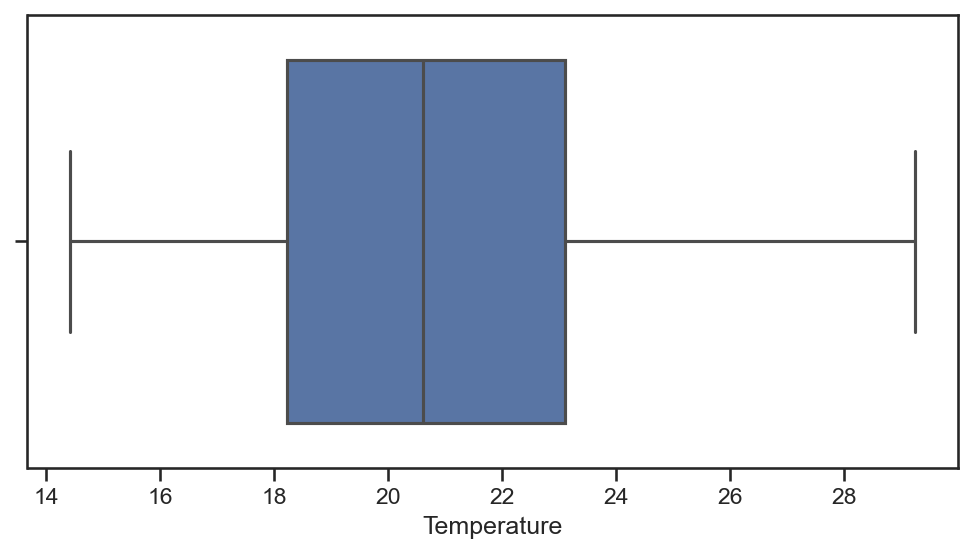

In [209]:
#checking for outliers
sns.boxplot(data=df, x="Temperature")

<AxesSubplot:xlabel='Longitude'>

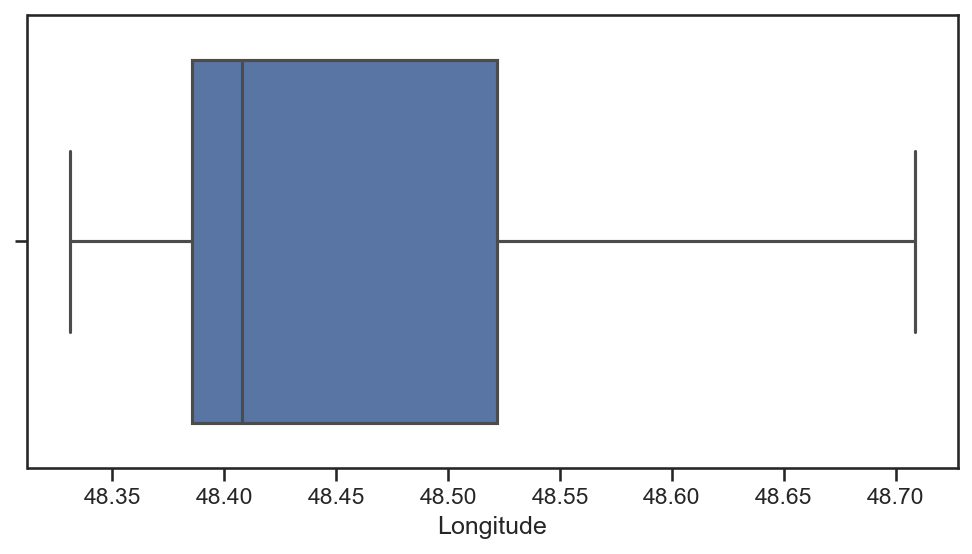

In [210]:
sns.boxplot(data=df, x="Longitude")

<AxesSubplot:xlabel='Latitude'>

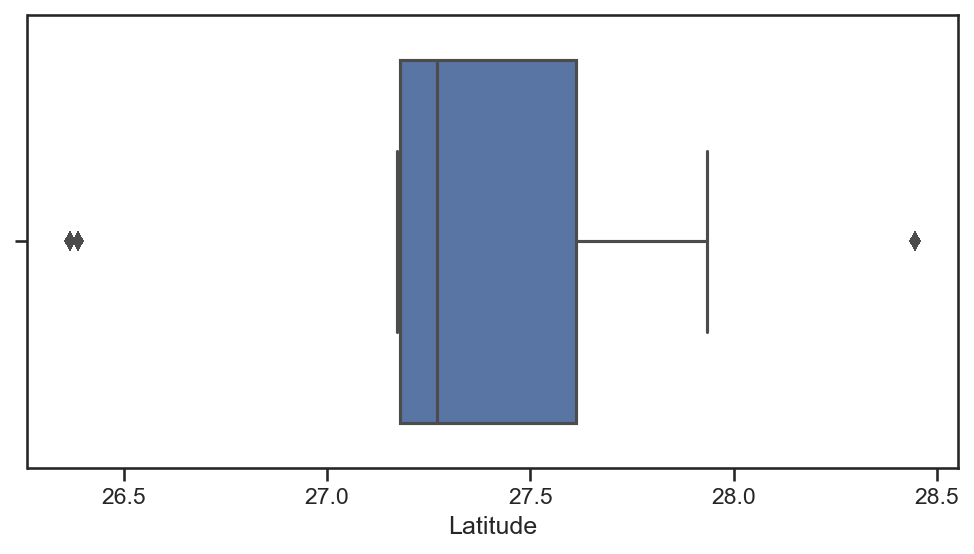

In [211]:
sns.boxplot(data=df, x="Latitude")

<AxesSubplot:xlabel='Depth'>

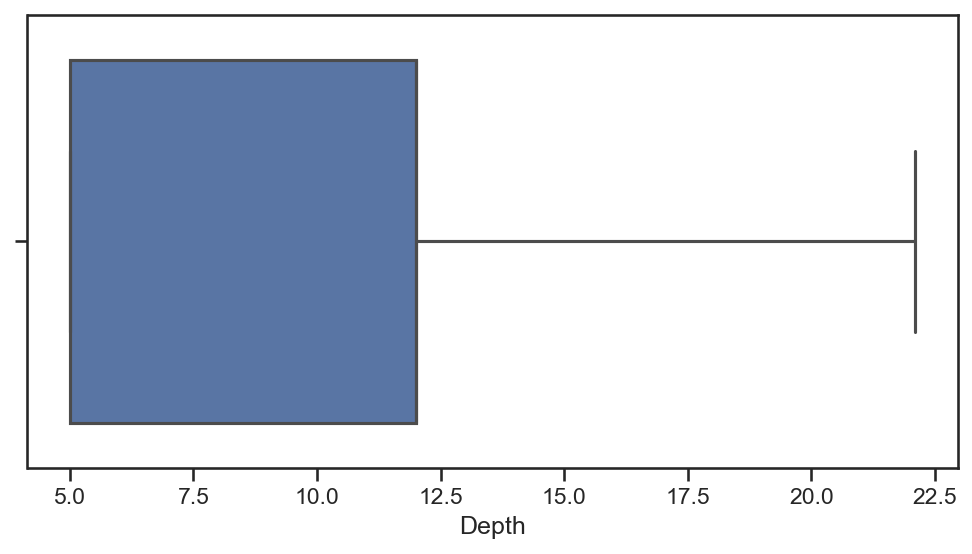

In [212]:
sns.boxplot(data=df, x="Depth")

In [213]:
#Making float Depth values to integer to remove outliers like 22.1 etc
df['Depth'] = df['Depth'].fillna(0).astype(int) 


In [214]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

#### Handling the dataset
The dataset does not require significant cleaning, however there were a few missing values in temperature column which were replaced with imputed with mean temperature. The dataset was cleaned to remove any duplicates. There were no outliers found. we convert the time and date columns to a datetime format using pd.to_datetime(). This allows us to extract specific components like hours, years, months.
and we converted Depth column from float to int to remove outliers.

#### Feature Extraction
We use the accessor like .dt.hour to extract the hour component from the datetime column and assign it to a new column called "hour", similarly for month and year in the dataset.

In [215]:
#Feature Extraction for date column
df['year']=df['Date'].dt.year 
df['month']=df['Date'].dt.month 

In [216]:
#Feture extraction for time column
df['hour'] = df['Time'].dt.hour

We extract features from time and date column and create hour, year and month column.

### Distributions, Moments
For this analysis, the numerical feature chosen is "Temperature (Celsius)". The data value space S is the set of all possible temperature measurements in degrees Celsius. To map it on a discrete S, we can choose intervals with bin width d. Let's choose the interval width of 1 degree Celsius, so the discrete value space S is {16, 17, 18, ..., 30}.

In [217]:
# Choose the numerical feature
temperature = df["Temperature"]

# Choose the interval width for the discrete value space
d = 1

# Define the discrete value space
S = np.arange(int(temperature.min()), int(temperature.max()) + d, d)

In [218]:
val, cnt = np.unique(S, return_counts=True)
pmf = cnt / len(S)

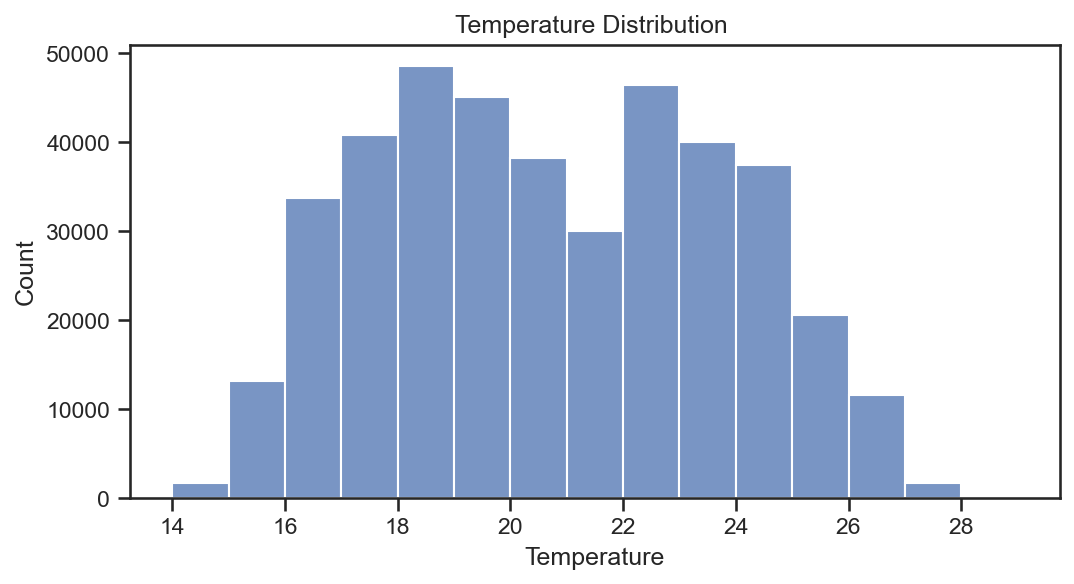

In [219]:
sns.histplot(temperature, bins=S)
plt.title('Temperature Distribution ')
plt.show()

Distribution of Numerical Variable - Temperature

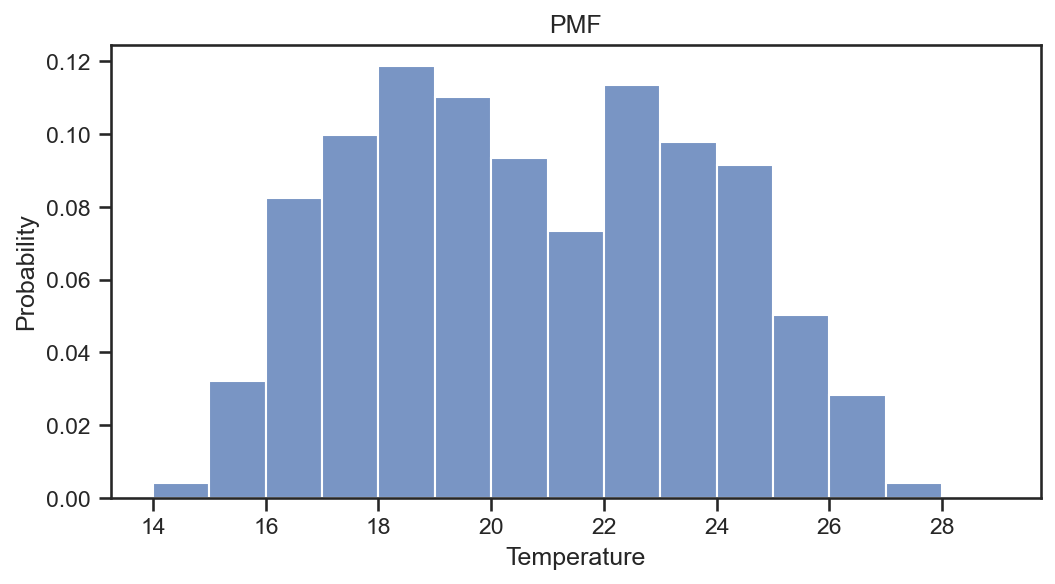

In [220]:
sns.histplot(temperature, stat='probability', bins=S)
plt.title('PMF')
plt.show()

In [221]:
pmf, bins = np.histogram(temperature, bins=S, density=True)
np.column_stack((bins[:-1], pmf))

array([[1.40000000e+01, 4.03292906e-03],
       [1.50000000e+01, 3.22047005e-02],
       [1.60000000e+01, 8.24817197e-02],
       [1.70000000e+01, 9.98761734e-02],
       [1.80000000e+01, 1.18631251e-01],
       [1.90000000e+01, 1.10176294e-01],
       [2.00000000e+01, 9.33691598e-02],
       [2.10000000e+01, 7.33953935e-02],
       [2.20000000e+01, 1.13497098e-01],
       [2.30000000e+01, 9.79331239e-02],
       [2.40000000e+01, 9.14579234e-02],
       [2.50000000e+01, 5.02182872e-02],
       [2.60000000e+01, 2.82549751e-02],
       [2.70000000e+01, 4.05984788e-03],
       [2.80000000e+01, 4.11123836e-04]])

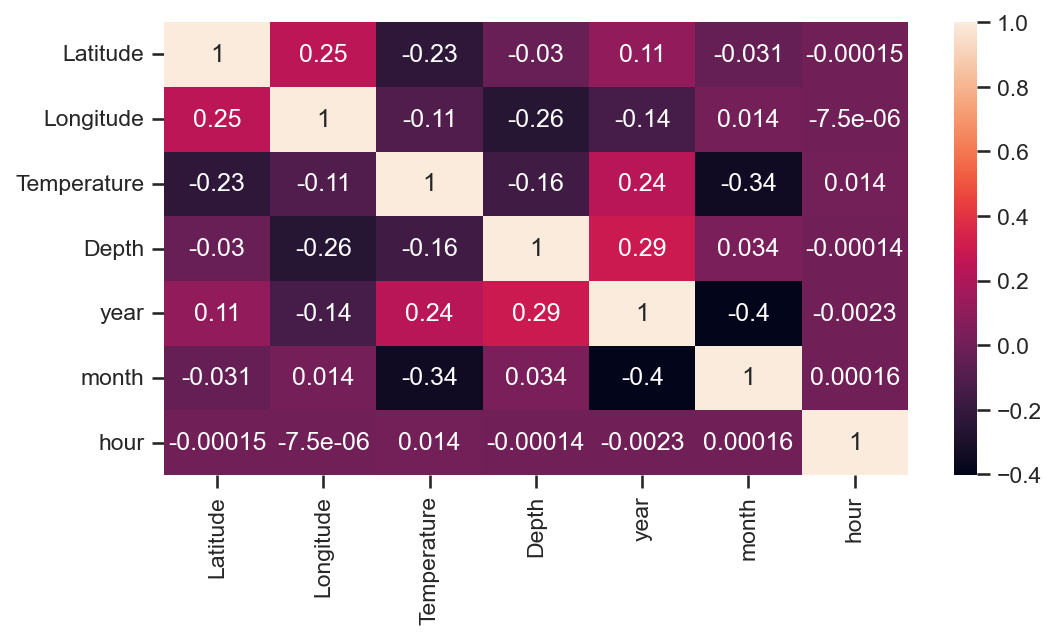

In [273]:
#Correlation Matrox Heatmap using Pearson Correlation
plt.figure(figsize = (8, 4))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [223]:
# Calculate the correlation coefficient
correlation = df['Depth'].corr(df['Temperature'])
print(f"Correlation Coefficient: {correlation}")

Correlation Coefficient: -0.16308931308406704


Negative correlation suggests as depth increases temperature decreases.
Month and temperature are negatively correlated - As we go through the year starting the temperature gradually decreases.

### Calculate the mean value, the standard deviation, the skewness 

In [224]:
# Here we have calculated the mean, standard deviation, skewness, and kurtosis of the temperature distribution
mean = temperature.mean()
std = temperature.std()
skew = temperature.skew()
kurtosis = temperature.kurtosis()

print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Skewness: {skew:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Mean: 20.76
Standard deviation: 2.98
Skewness: 0.09
Kurtosis: -1.03


In [225]:
m= df['Depth'].unique()
##print(m)
for d in m:
    #print(d)
    mean = df.loc[df["Depth"] == float(d)].Temperature.mean()
    print('Mean Temperature at', d, 'is', mean)

Mean Temperature at 12 is 20.951966892250663
Mean Temperature at 5 is 21.148199187889947
Mean Temperature at 22 is 19.806352021331076


In [226]:
np.histogram(temperature, bins=S, density=True)[0]

array([0.00403293, 0.0322047 , 0.08248172, 0.09987617, 0.11863125,
       0.11017629, 0.09336916, 0.07339539, 0.1134971 , 0.09793312,
       0.09145792, 0.05021829, 0.02825498, 0.00405985, 0.00041112])

In [227]:
xx=df['Temperature'].count()

In [228]:
data_normal = norm.rvs(size=xx,loc=mean,scale=std)

In [229]:
from sklearn.metrics import mean_squared_error
data_pred = np.histogram(data_normal, bins=S, density=True)[0]
data_temp= np.histogram(temperature, bins=S, density=True)[0]
mean_squared_error(data_temp, data_pred)

0.0006931437546178087

In [230]:
temp_bin_width = 0.5
depth_bin_width = 5

Text(0, 0.5, 'Frequency')

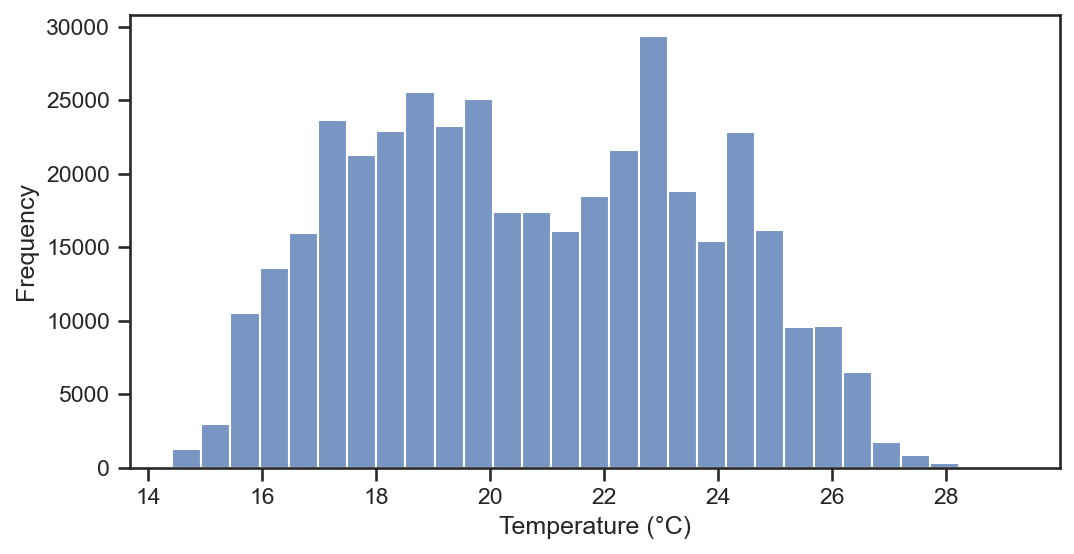

In [231]:
ax1=sns.histplot(df['Temperature'], bins=int((df['Temperature'].max() - df['Temperature'].min()) / temp_bin_width))
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Frequency')

inSIGTHS-
Distribution of temperature variable - it was a continuous variable, bins width= 0.5 used to make discrete.

TypeError: fit() missing 1 required positional argument: 'data'

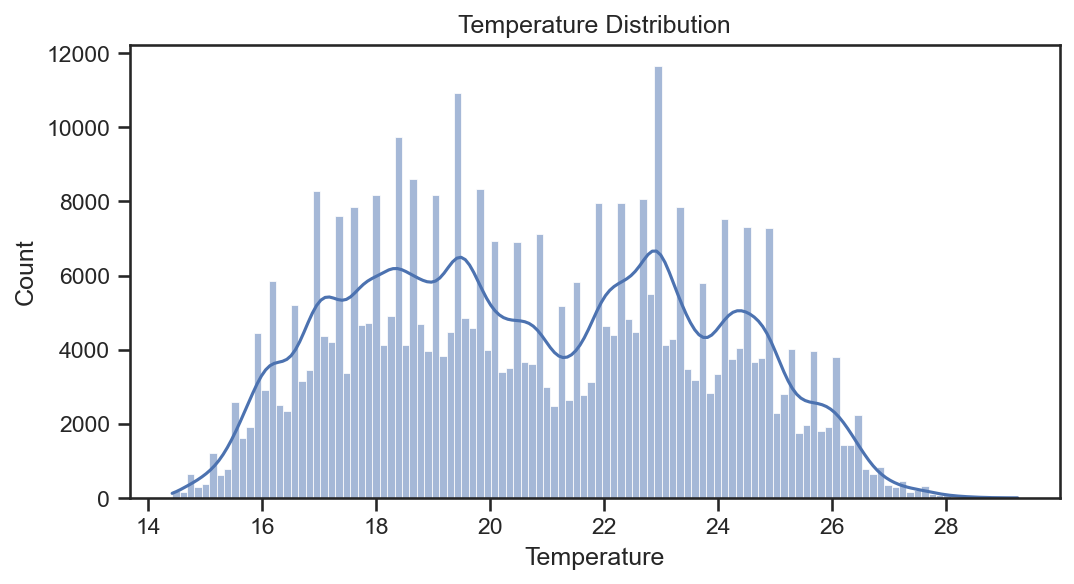

In [232]:
# Plotting the temperature distribution
sns.histplot(df['Temperature'], kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Count')
x= df['Temperature']
# Identify the distribution type
dist_type = stats.distributions.rv_continuous.fit(x)
dist_name = dist_type.__class__.__name__

plt.text(0.98, 0.9, f'Distribution: {dist_name}', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

In [234]:
temp_dist = df["Temperature"].values

In [235]:
f = Fitter(temp_dist,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()





Fitting 5 distributions: 100%|██████████| 5/5 [00:30<00:00,  6.00s/it]


lognorm was not fitted. no parameters available
burr was not fitted. no parameters available


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.102926,643.839052,-6.208928e+06,0.097857,0.056132,0.0
gamma,0.129428,622.711043,-6.115317e+06,0.137824,0.061064,0.0
norm,0.131285,625.621354,-6.109509e+06,0.134808,0.061433,0.0
lognorm,inf,inf,inf,inf,NaN,NaN
burr,inf,inf,inf,inf,NaN,NaN


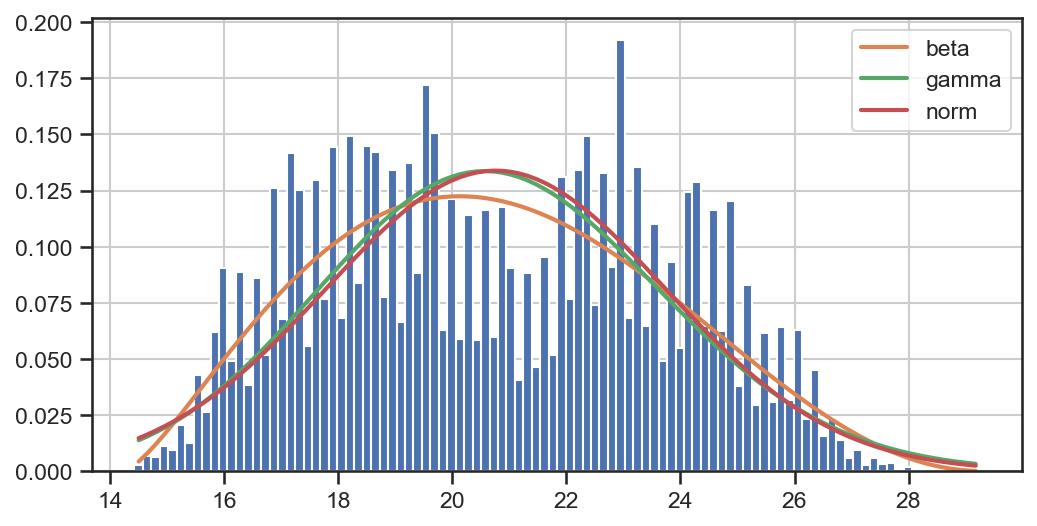

In [236]:
f.summary()

In [237]:
f.get_best(method = 'sumsquare_error')

{'beta': {'a': 2.428573568796736,
  'b': 3.24332939508105,
  'loc': 14.226135289237561,
  'scale': 15.16388864094111}}

Insights-
Different distributions were used to fit the data, sum of square metric was used as error measurement. 
The best distribution was beta distribution with the following parameters.

Text(0, 0.5, 'Frequency')

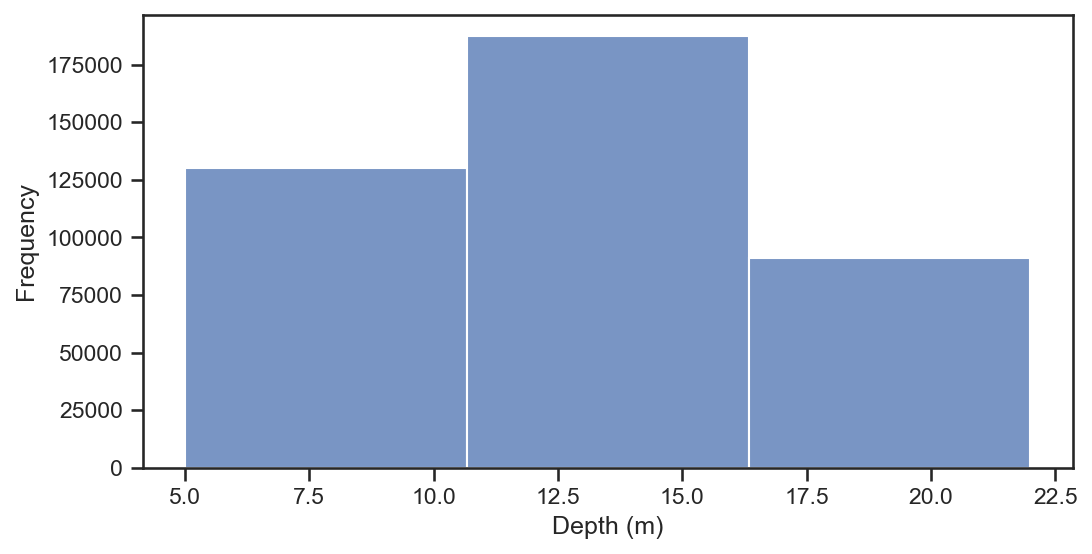

In [238]:
ax2 = sns.histplot(df['Depth'], bins=int((df['Depth'].max() - df['Depth'].min()) / depth_bin_width))
ax2.set_xlabel('Depth (m)')
ax2.set_ylabel('Frequency')

Text(0, 0.5, 'Temperature (°C)')

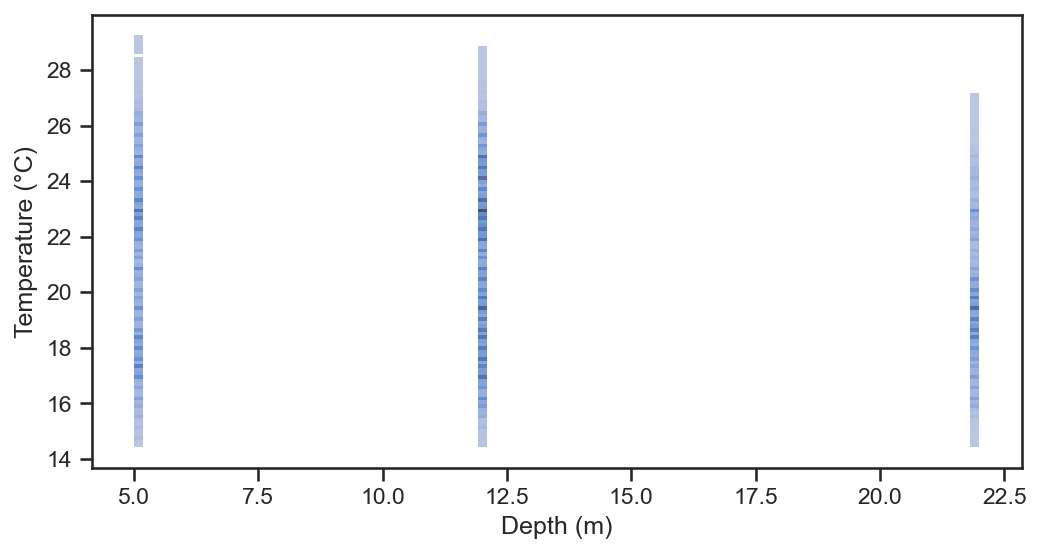

In [239]:
#Histogram plot of Temperature and depth
sns.histplot(data=df, x='Depth', y='Temperature')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')

### Insights

Here we can see the variance in the temperature.
1. Temperature is varying throught the day for all three depths
2. At 5m depth, we see the temperature is varying a lot, which is correct as at 5m the sunlight affects the surface water temperature.
3. At 12m depth, a deep blue band shows a mean temperature of 24 degrees C. Which shows the variation in tempearuture is decreasing.
4. At 22m depth, the variation in temperature further decreases hence a shorter line, temp does not vary much due to less sunlight also it can be seen that the mean (deep blue band) is around 20 degree C, Thus the mean temperature has also decreased.
5. The variation and mean temperature decreases as the depth increases hence the two variables are negatively correlated.

## Distributions with Time

In [240]:
#we create month and temperature probability distributions at deiffertent depths
dx = df.loc[df['Depth']== 5] #At depth 5
ds = df.loc[df['Depth']== 12] #at depth 12
dv = df.loc[df['Depth']== 22] #at depth 22

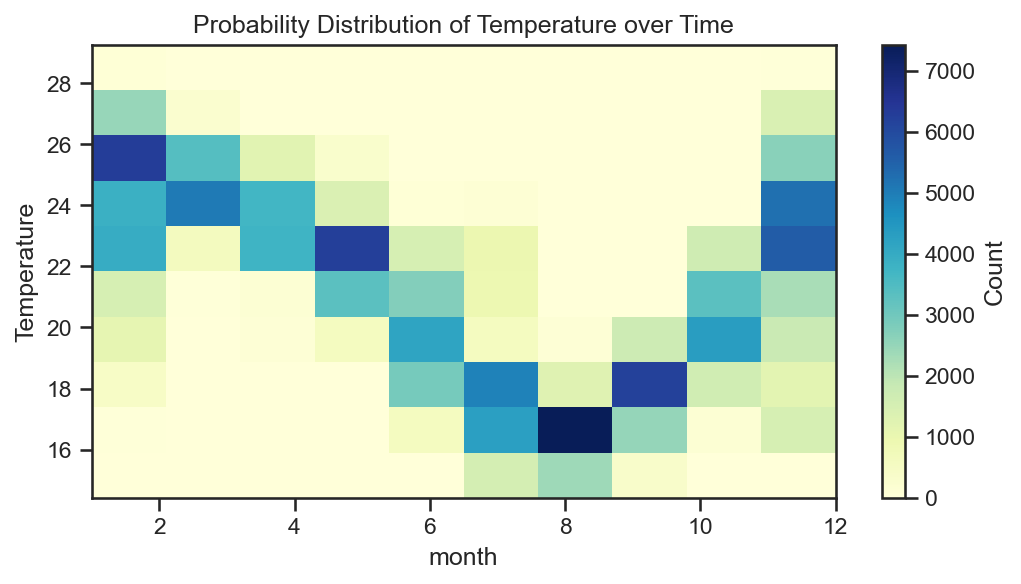

In [260]:
# Plotting the heatmap month and temperature at depth 5m
plt.figure(figsize=(8, 4))
plt.hist2d(dx['month'], dx['Temperature'], cmap='YlGnBu')
plt.colorbar(label='Count')
plt.title('Probability Distribution of Temperature over Time')
plt.xlabel('month')
plt.ylabel('Temperature')
plt.show()

Probability distribution of temperature over time at different depths
1. At 5m Depth- We can see a downward trend the mean temperature during hot month is 20-26, that gradually decreases as we move to winters the mean decreases between 16-18 degrees C and again increases as we move to summer months.
2. At 12m Depth - We can see high variation in summers, except summer months similar pattern is observed as in 5m depth.
3. At 22m Depth - Even in early summer months the mean temp is not deep blue showing temperature is not very high due to depth, in winter month not much variation, and it very slowly increases as summer approaches again, in general the temperature remains colder compared to other depths over the whole year.


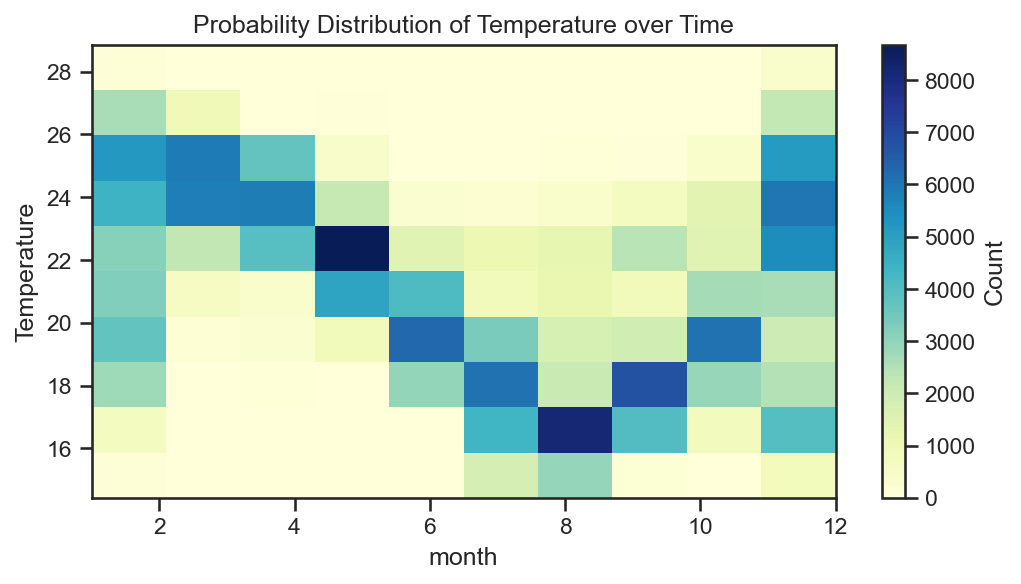

In [261]:
# Plotting the heatmap month and temperature at depth 12m
plt.figure(figsize=(8, 4))
plt.hist2d(ds['month'], ds['Temperature'], cmap='YlGnBu')
plt.colorbar(label='Count')
plt.title('Probability Distribution of Temperature over Time')
plt.xlabel('month')
plt.ylabel('Temperature')
plt.show()

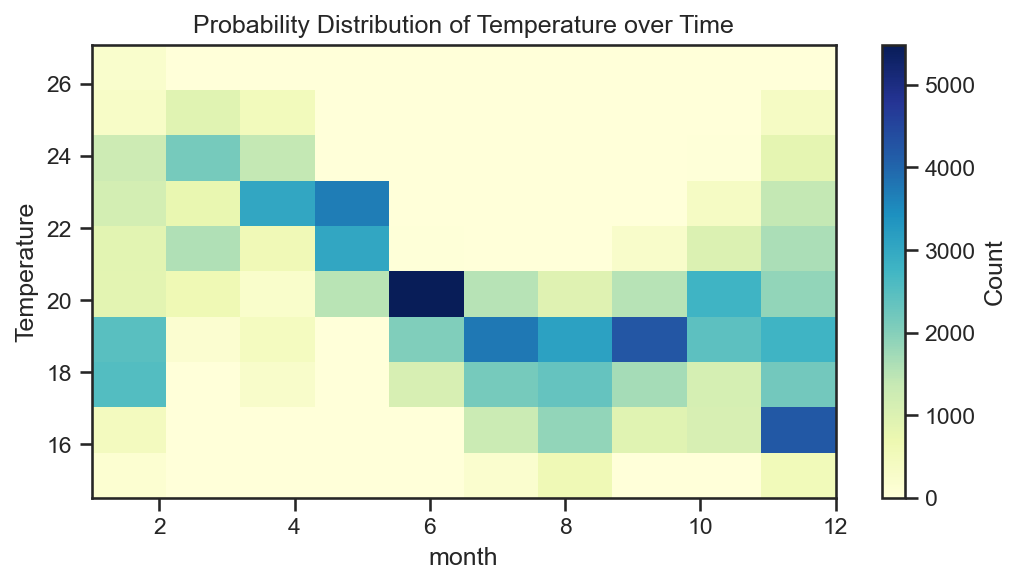

In [262]:
# Plotting the heatmap month and temperature at depth 22 m
plt.figure(figsize=(8, 4))
plt.hist2d(dv['month'], dv['Temperature'], cmap='YlGnBu')
plt.colorbar(label='Count')
plt.title('Probability Distribution of Temperature over Time')
plt.xlabel('month')
plt.ylabel('Temperature')
plt.show()

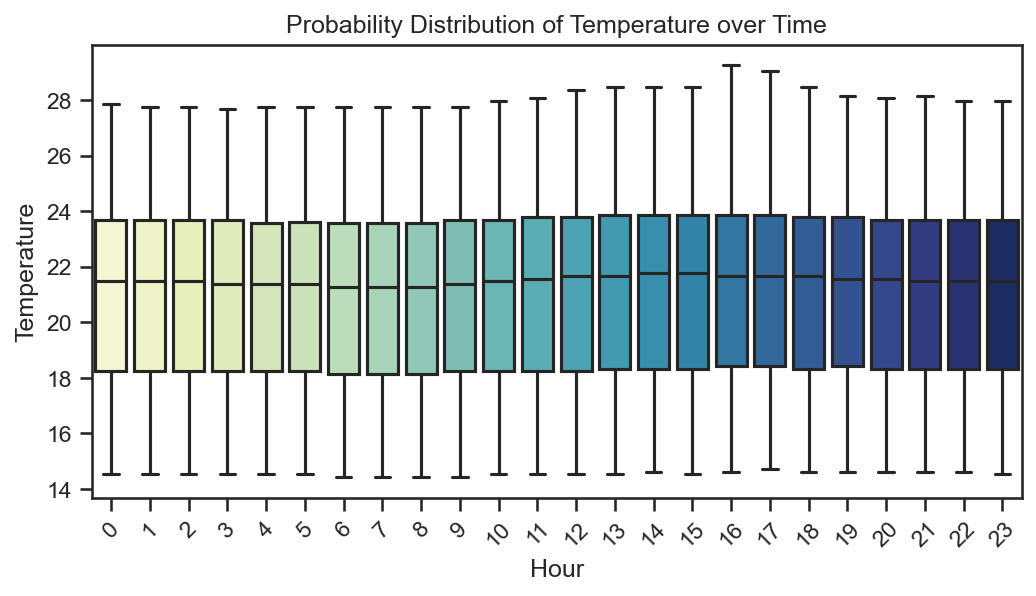

In [263]:
# Plotting the box plot for hour and temp at depth 5
sns.boxplot(x=dx['hour'], y=dx['Temperature'], palette='YlGnBu')
plt.title('Probability Distribution of Temperature over Time')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

Insights -
1. At 5m Depth - We can clearly see how the mean temperature varies all over the day.The mean temperature is high during afternoon hours that is between 1200hrs to 1700 hrs. it is colder during night and early morning.
2. At 12m Depth - Not much variation is observed, there is a slight increase in temperature during afternoon.
3. At 22m Depth - The small variation in the box plot from the mean suggests that the temperature does not vary a lot throughout the day and the year as well. It stays in the range 19-22 degree C. 

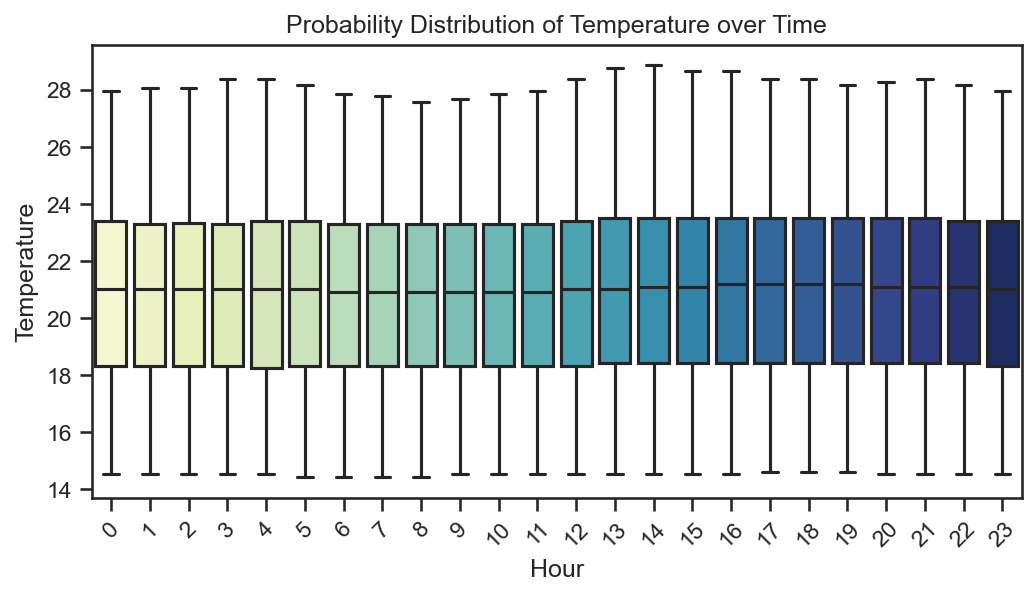

In [245]:
# Plotting the box plot for hour and temp at depth 12
sns.boxplot(x=ds['hour'], y=ds['Temperature'], palette='YlGnBu')
plt.title('Probability Distribution of Temperature over Time')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

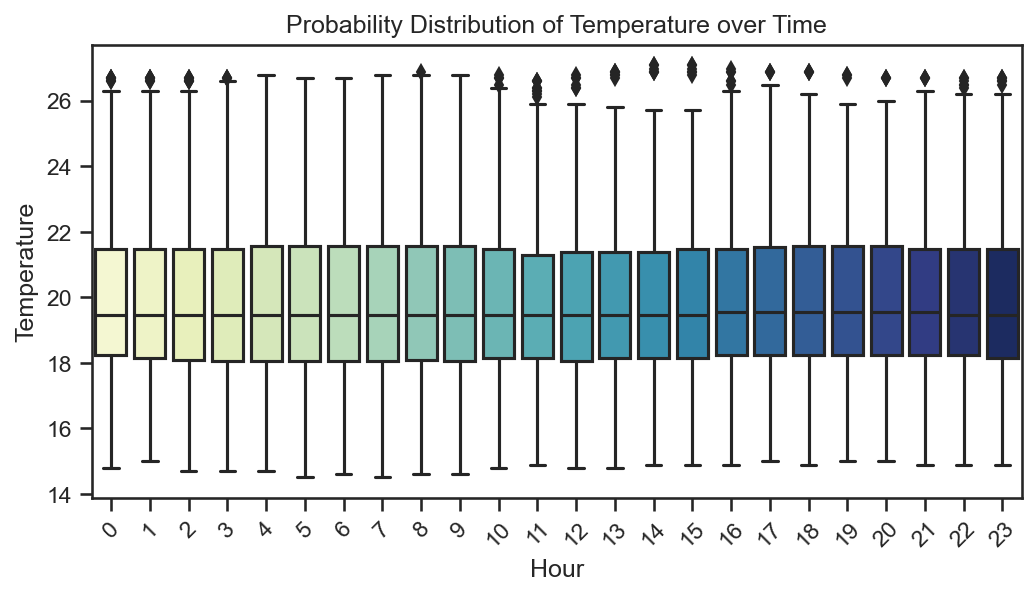

In [264]:
# Plotting the box plot for hour and temp at depth 22m
sns.boxplot(x=dv['hour'], y=dv['Temperature'], palette='YlGnBu')
plt.title('Probability Distribution of Temperature over Time')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

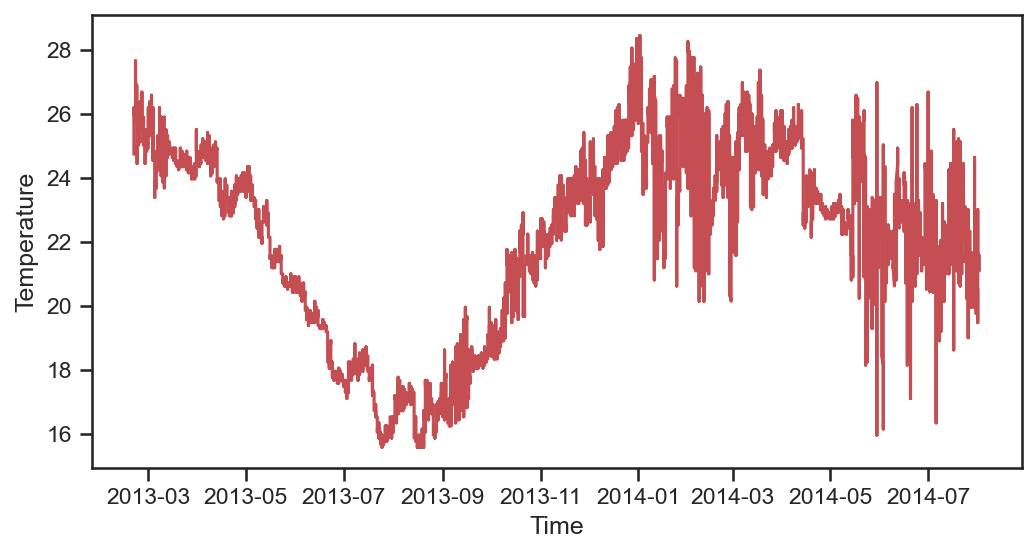

In [247]:
# Plotting the timeseries month and temperature at depth 5m
dg = dx.loc[dx['Site'] == 'Ilha Deserta']
plt.plot(dg['Date'], dg['Temperature'], color = 'r')
#plt.plot(ds['Temperature'], dx['Date'], color = 'b')
#plt.plot(dv['Temperature'], dx['Date'], color = 'g')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

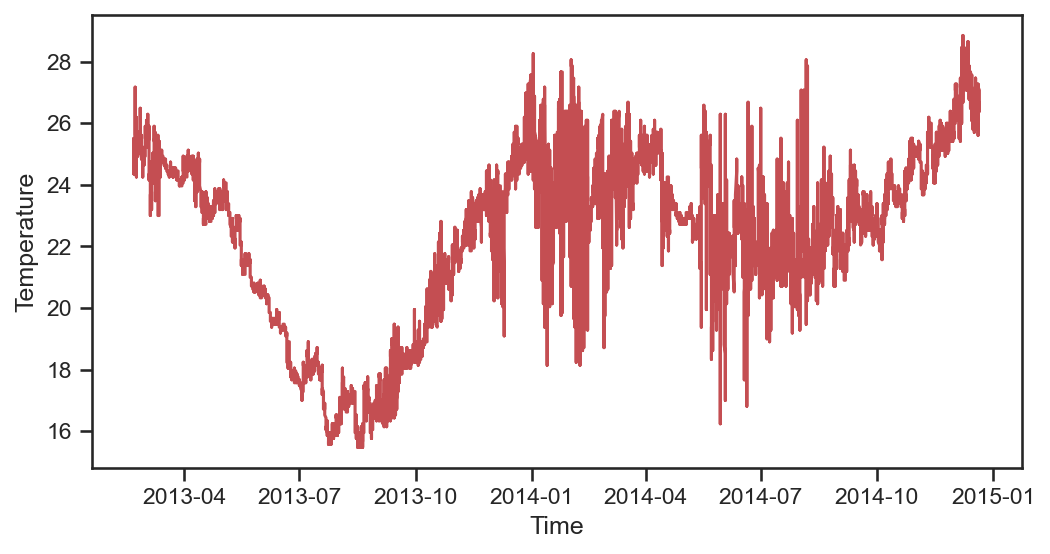

In [271]:
# Plotting the timeseries month and temperature at depth 12m
dh = ds.loc[ds['Site'] == 'Ilha Deserta']
plt.plot(dh['Date'], dh['Temperature'], color = 'r')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

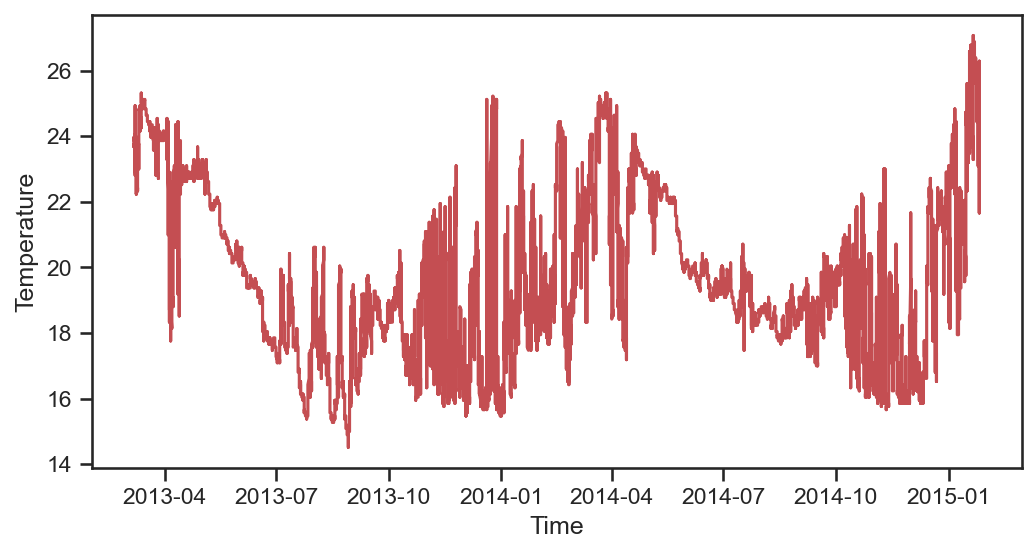

In [249]:
# Plotting the timeseries month and temperature at depth 5m
dj = dv.loc[dv['Site'] == 'Parcel do Xavier (Alalunga)']
plt.plot(dj['Date'], dj['Temperature'], color = 'r')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

Insights 
To check the seasonality we have plotted the temperature as a time series, to do this we have plotted the temperature time series at three depths at different locations-Ilha Deserta, Parcel do Xavier (Alalunga).
We can clearly see the seasonality because of the different seasons throughout the year as the ambient temperature changes. 
These graphs also verify the previous charts that we created and verifies the insights.

## Joint Probabilty Matrix

In [250]:
# Select the relevant columns for analysis
variables = ['Depth', 'Temperature']
selected_data = df[variables]

In [251]:
# Calculate the joint probability matrix
joint_prob_matrix = pd.crosstab(selected_data['Depth'], selected_data['Temperature'], normalize=True)

print(joint_prob_matrix)

Temperature    14.421    14.517    14.613    14.709    14.804    14.900  \
Depth                                                                     
5            0.000012  0.000135  0.000113  0.000372  0.000693  0.000367   
12           0.000024  0.000252  0.000252  0.000232  0.000213  0.000299   
22           0.000000  0.000010  0.000024  0.000017  0.000022  0.000059   

Temperature    14.996    15.091    15.187    15.282  ...    28.258    28.357  \
Depth                                                ...                       
5            0.000394  0.000543  0.000653  0.000592  ...  0.000027  0.000024   
12           0.000475  0.000683  0.000781  0.000852  ...  0.000044  0.000059   
22           0.000069  0.000171  0.000125  0.000081  ...  0.000000  0.000000   

Temperature    28.456    28.555    28.655    28.754    28.853    28.953  \
Depth                                                                     
5            0.000017  0.000000  0.000002  0.000005  0.000002  0.000002  

we use the pd.crosstab() function to calculate the joint probability matrix. This function computes a cross-tabulation table, which represents the frequencies or counts of different combinations of the two variables. By specifying normalize=True, the frequencies are converted to probabilities, resulting in the joint probability matrix.

The joint Probability matricx shows water depths as rows and the temperature values as columns. Each cell of the matrix represents the probability of a specific combination of water depth and temperature occurring in the dataset.The values i range between 0 and 1, where 0 represents a combination that doesn't occur in the dataset, and 1 represents a combination that always occurs in the dataset. 

We can see that for high temperatures like 28 to 29 degree celsius we get Value of cell as 0 for depths 12m and 22m. Which shows probability of these high temperatures is 0 at higher depths. Because temperatures are lower in these places.

The joint probability matrox reveals the dependecy of temperatures on Depth of water. Thus, helping us gain a deeper understanding of how water depth influences the temperature in the dataset. 
Independent variable - Depth. Temperature - Dependent Variable

In [252]:
most_probable_temperatures = joint_prob_matrix.idxmax()

most_probable_temperatures

Temperature
14.421    12
14.517    12
14.613    12
14.709     5
14.804     5
          ..
28.754     5
28.853     5
28.953     5
29.053     5
29.252     5
Length: 155, dtype: int64

Using the matrix here we can observe the most probable temperature values at different water depths.
The idxmax() function is used to find the indices (column labels) corresponding to the maximum value in each row of the joint probability matrix. This indicates the most probable temperature value for each water depth.
At 12m depth the highest probabilty of temperature is 14 degrees.

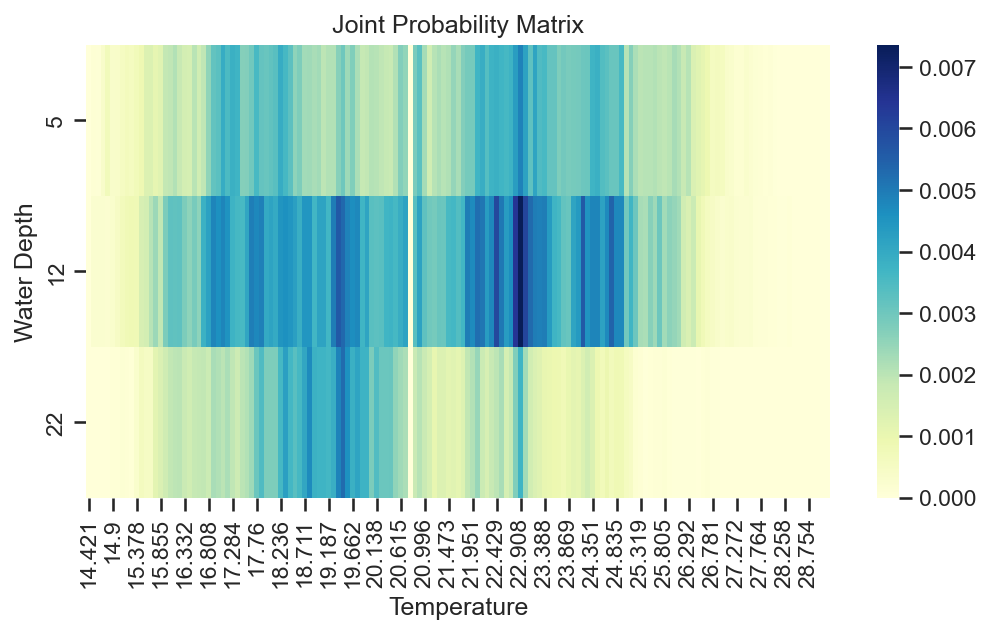

In [265]:
# Plotting the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(joint_prob_matrix, cmap="YlGnBu")
plt.title("Joint Probability Matrix")
plt.xlabel("Temperature")
plt.ylabel("Water Depth")
plt.show()
#indicates low probabilities with yellow and high probabilities with shades of blue.

### Insights
To identify patterns in the distribution of the joint probability matrix,create a heatmap that visualizes the probabilities using color gradients. 
The x-axis represents the temperature values, while the y-axis represents the water depths. The colors in the heatmap indicate the probability values, with the color intensity corresponding to the probability magnitude.
We can observe areas of higher probabilities (indicating strong associations).
or areas of lower probabilities (indicating weaker associations).
we can again see here that because of highly varying temperatures at 5m depth we see a lot of gradient. But for 22m depth we see less color as variation is decreasing with depth.

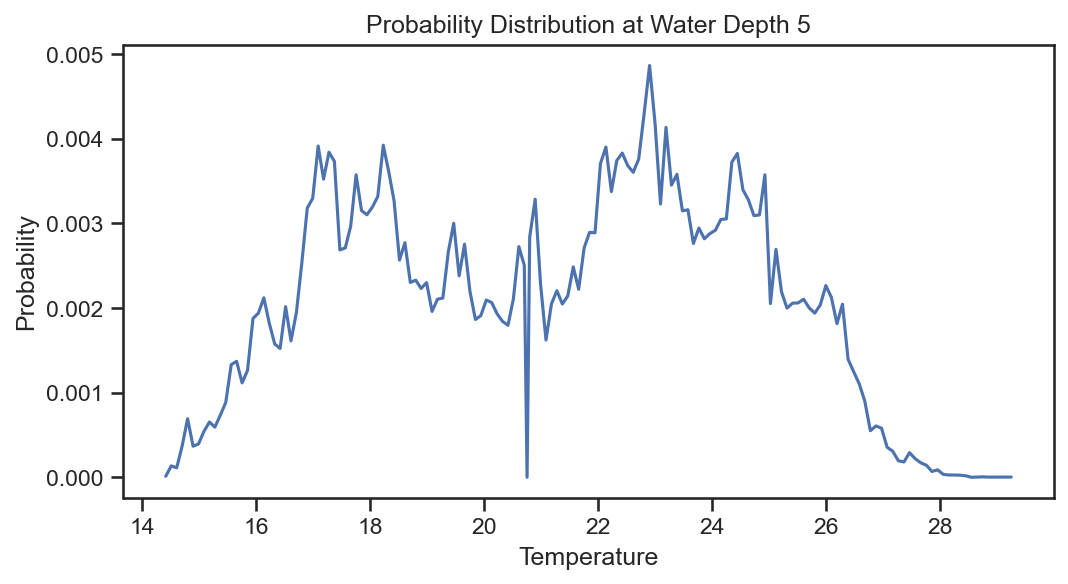

In [266]:
#Line Plot

# We Select a specific water depth for analysis
water_depth = 5

# Plotting the line plot
plt.figure(figsize=(8, 4))
plt.plot(joint_prob_matrix.loc[water_depth])
plt.title(f"Probability Distribution at Water Depth {water_depth}")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.show()

To analyze the probability distribution we plot a line plot to visualize the probabilities of different temperature values at that particular water depth. 
1. At 5m - we can see peaks at 18 and 22, for summer winter months- These are the most probable temperatures.
2. At12 m -Peaks at 16-20 and 23, for summer winter months- These are the most probable temperatures.
3. At 22m - Very little variation and peak at 18-19 - Most probable temperature.

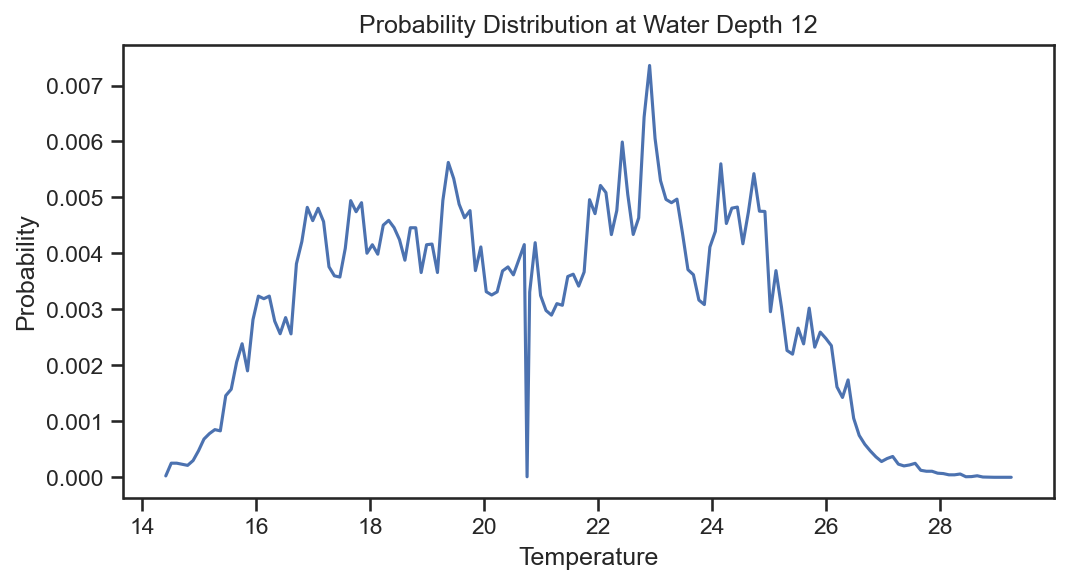

In [267]:
#Line Plot

# We Select a specific water depth for analysis
water_depth = 12

# Plotting the line plot
plt.figure(figsize=(8, 4))
plt.plot(joint_prob_matrix.loc[water_depth])
plt.title(f"Probability Distribution at Water Depth {water_depth}")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.show()

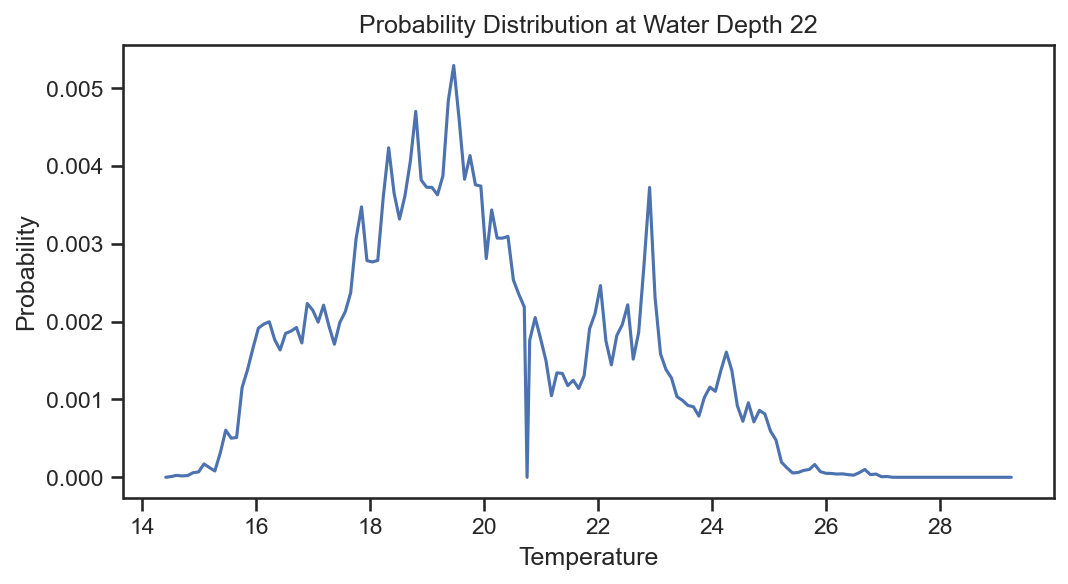

In [268]:
#Line Plot

# We Select a specific water depth for analysis
water_depth = 22

# Plotting the line plot
plt.figure(figsize=(8, 4))
plt.plot(joint_prob_matrix.loc[water_depth])
plt.title(f"Probability Distribution at Water Depth {water_depth}")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.show()

We plot a line graph to... 
For 5m Depth-
1. We can see the probability distribution is 

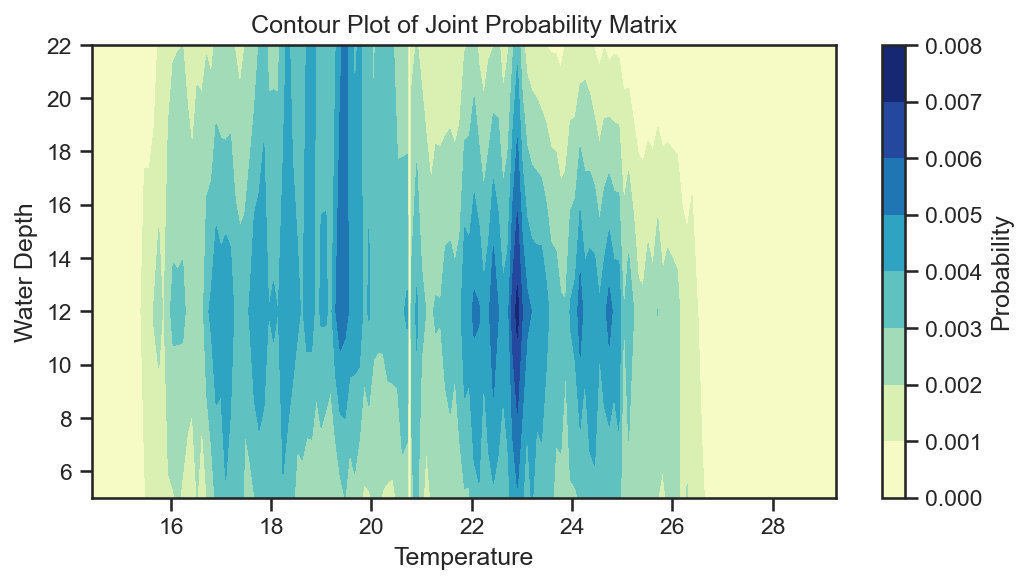

In [269]:
#Contour plot

# Creating meshgrid for water depths and temperature values
water_depths = joint_prob_matrix.index.values
temperature_values = joint_prob_matrix.columns.values
X, Y = np.meshgrid(temperature_values, water_depths)

# Converting joint probability matrix to 2D array
Z = joint_prob_matrix.values

# Plotting the contour plot
plt.figure(figsize=(8, 4))
plt.contourf(X, Y, Z, cmap="YlGnBu")
plt.colorbar(label="Probability")
plt.title("Contour Plot of Joint Probability Matrix")
plt.xlabel("Temperature")
plt.ylabel("Water Depth")
plt.show()


### Insights
we create a contour plot to visualize the joint probability matrix. We use the meshgrid function from NumPy to create a grid of temperature values and water depths. Then, we convert the joint probability matrix to a 2D array. The contour plot represents the probabilities as contours, with different colors indicating different probability levels.
Here the water depths are indicated on y-axis and temperature on x-axis. 
We can clearly see two clusters, one for high mean temperatures between 21-25 degree C, which mainly lies between 5m and 12m depths. and the one for low mean temperatures between 16-19 degree C for 12m  and 22 m. 


## Checking linear dependencies between variables

We now compute linear regressions and assess the presence and strength of linear dependencies between the numerical variables "depth" and "temperature" in the dataset, using the statsmodels library.

In [258]:
# Select the variables for regression
X = df['Depth']  # Independent variable (depth)
y = df['Temperature']  # Dependent variable (temperature)

# Add constant term to the independent variable
X = sm.add_constant(X)

# Perform linear regression
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        19:21:14   Log-Likelihood:            -1.0205e+06
No. Observations:              408638   AIC:                         2.041e+06
Df Residuals:                  408636   BIC:                         2.041e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7060      0.010   2154.850      0.0

As per our previous analysis we select "depth" variable as the independent variable (X) and the "temperature" variable as the dependent variable (y). we add a constant term to the independent variable using sm.add_constant(X). This ensures that the linear regression model includes an intercept term.

The regression results summary -
1. t-Statistics: of depth is very positive, indicating the independent and dependent varisbles shows a strong relation. A larger value t value indicates significant difference between the two variables, which is correct since they are negatively correlated.
2. p value :Generally, a p-value threshold of 0.05 (or lower) is used to determine statistical significance. Here we have a low p-value <0.05, which is good and shows high statistical significance.
3. Goodness-of-Fit Measures:
a. R-squared (R2): R-squared measures the proportion of the variance in the dependent variable that is explained by the independent variable(s). It ranges from 0 to 1, with higher values indicating a better fit.We got R2 as 0.757 which is closer to 1 hence a good fit.
b. Adjusted R-squared: Adjusted R-squared takes into account the number of independent variables and the sample size, providing a penalized version of R-squared. It helps prevent overfitting by adjusting for the degrees of freedom, with higher values indicating a better balance. We got the Adjusted R2 as 0.75 which is again a high value.

Hence we conclude our linear regression model is a good fit.


In [272]:
X = df['Depth']  # Independent variable (depth)
y = df['Temperature']  # Dependent variable (temperature)

# Add constant term to the independent variable
#X = sm.add_constant(X)

# Perform linear regression
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            Temperature   R-squared (uncentered):                   0.757
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                          1.273e+06
Date:                Wed, 31 May 2023   Prob (F-statistic):                        0.00
Time:                        20:25:13   Log-Likelihood:                     -1.5343e+06
No. Observations:              408638   AIC:                                  3.069e+06
Df Residuals:                  408637   BIC:                                  3.069e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

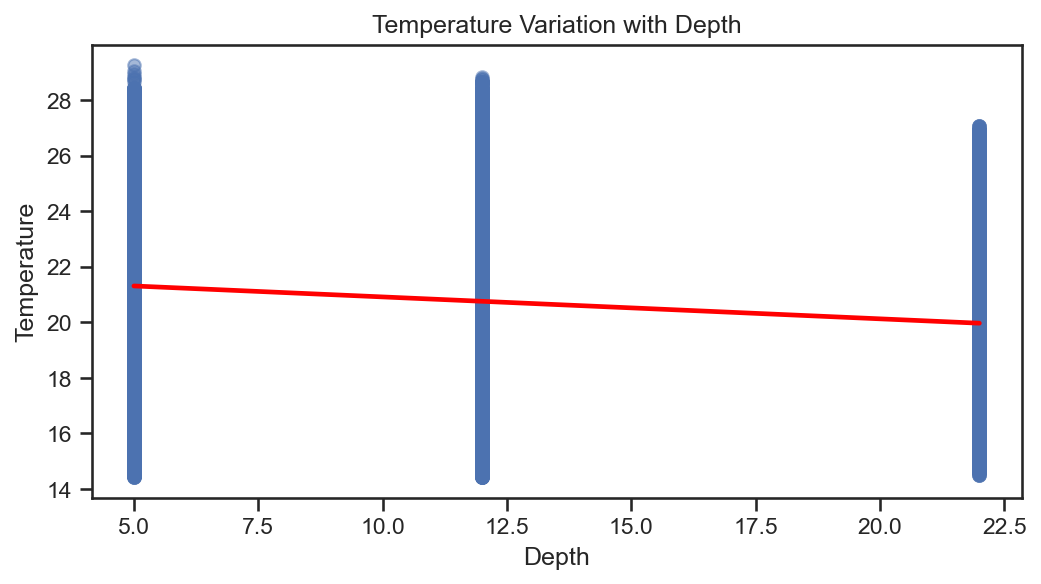

In [270]:
# Plotting the scatter plot with trend line
plt.figure(figsize=(8, 4))
sns.regplot(x=df['Depth'], y=df['Temperature'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Temperature Variation with Depth')
plt.xlabel('Depth')
plt.ylabel('Temperature')
plt.show()

# Results and Conclusion

The analysis of the 'Underwater Surface Temperature Dataset' revealed several insights about the relationship between depth, temperature, and time. Here are the key findings:
1. Negative Correlation: There is a negative correlation between depth and temperature. As depth increases, the temperature tends to decrease. This observation aligns with the understanding that water temperature generally decreases with increasing depth due to factors like sunlight penetration.

2. Temperature Variation with Time and Depth: There is a negative correlation between month and temperature. As the year progresses, starting from summer, the temperature gradually decreases. This pattern indicates a seasonal variation in temperature, with colder temperatures during winter months. The temperature variations throughout the day were observed for different depths. At less depth, the temperature showed significant variation, which can be attributed to the influence of sunlight on the surface water temperature, the temperature variations decreased as the depth increased, At 22m depth, the temperature showed even less variation, indicating a colder and more stable environment.  

3. Different distributions were used to fit the data, and the sum of square metrics was used as an error measurement. The best distribution was found to be the beta distribution. 

4. Joint Probability Matrix: The joint probability matrix demonstrated the dependence of temperature on water depth. It provided a deeper understanding of how water depth influences the temperature in the dataset, with higher depths having lower probabilities of high temperatures. Probability distribution plots were created to visualize the temperature distribution over time and at different depths. The plots revealed the most probable temperature values for each depth and highlighted the variations in temperature during different seasons.

5. Lastly we computed a Linear regression model to assess the presence and strength of linear dependencies between the numerical variables "depth" and "temperature." The regression results indicated a strong negative relationship between the variables. The t-statistics showed significant differences, and the low p-value indicated high statistical significance. The goodness-of-fit measures, R-squared and adjusted R-squared, indicated that the linear regression model provided a good fit to the data.

In conclusion, the analysis of the 'Underwater Surface Temperature Dataset' revealed important insights about the relationships between depth, temperature, and time. The negative correlation between depth and temperature, along with the seasonal temperature variations, showcased the impact of environmental factors on water temperature. The probability distribution and linear regression analysis provided further understanding of the statistical structures and dependencies in the dataset. These findings contribute to the broader understanding of underwater temperature dynamics and can be valuable for studying marine ecosystems and climate change impacts on coastal regions.

As climate change continues to affect coastal areas, understanding the impacts on underwater temperature becomes crucial. Future research can utilize this dataset to assess the long-term effects of climate change on underwater surface temperature. This can help predict and mitigate potential consequences such as habitat loss, shifts in species composition, and overall ecosystem functioning.The relationship between underwater temperature and ecological processes is of great interest. Future studies can utilize this dataset to investigate the impact of temperature variations on marine organisms,This information can contribute to better understanding and management of marine ecosystems and aid in conservation efforts.

# Future Scope:
 
The "Underwater Surface Temperature Dataset" offers a wide range of possibilities for future research and applications in the fields of marine science, ecology, climate change, and environmental management. The dataset's temporal and spatial coverage, combined with its rich temperature records, makes it a valuable resource for advancing our understanding of underwater temperature dynamics and their ecological implications.

Modeling and Predictive Analysis: The dataset can serve as a foundation for developing predictive models that can estimate underwater surface temperature based on factors such as depth, location, and time of sampling. These models can be valuable tools for researchersand stakeholders involved in coastal management and conservation, providing insights into future temperature scenarios and aiding in decision-making processes.

# References
1. https://www.kaggle.com/datasets/shivamb/underwater-surface-temperature-dataset
2. https://doi.org/10.17882/62120
3. https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af
4. https://www.scribbr.com/statistics/pearson-correlation-coefficien